# Exercise 2

In this session we discuss about other softwares and libriaries can be also used to access and write to PostGIS.
We will see a few libraries in R and check SAGA GIS.

Install and load the libraries
https://cran.r-project.org/web/packages/rpostgis/rpostgis.pdf

In [1]:
#install.packages(c("rgdal", "raster",  "rgdal",  "rpostgis", "sp", "cluster", "tictoc"))
library(rgdal)
library(raster)
library(rpostgis)
library(cluster)
#http://remote-sensing.eu/unsupervised-classification-with-r/ 
library(tictoc)
#set working directory
dw <- setwd('/opt/workshop/exercise_2') 

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning message in install.packages(c("rgdal", "raster", "rgdal", "rpostgis", "sp", :
“installation of package ‘cluster’ had non-zero exit status”Loading required package: sp
rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 
Loading required package: RPostgreSQL
Loading required package: DBI


Let's import our raster data as usual, calling it from the terminal

Tictoc is a library for measuring the time our queries take: 14 s for this one

In [2]:
tic()
system('raster2pgsql -s 3794 -I /opt/workshop/exercise_2/dof.tif -t 100x100 -Y -C dof | psql -h localhost -d giws -U user')
system('raster2pgsql -s 3794 -I /opt/workshop/exercise_2/dofir.tif -t 100x100 -Y -C dofir | psql -h localhost -d giws -U user')
toc()

14.025 sec elapsed


Let's connect to the database and read our raster

In [3]:
conn <- dbConnect("PostgreSQL", dbname = 'giws', host = 'localhost', user = 'user', password = 'user')

#100 s
tic()
dofir <- stack(pgGetRast(conn, c("public","dofir"), bands=TRUE, rast = 'rast', boundary = NULL))
toc()

96.901 sec elapsed


Now we can visualize and manipulate the raster data with all the possibilities that R offers

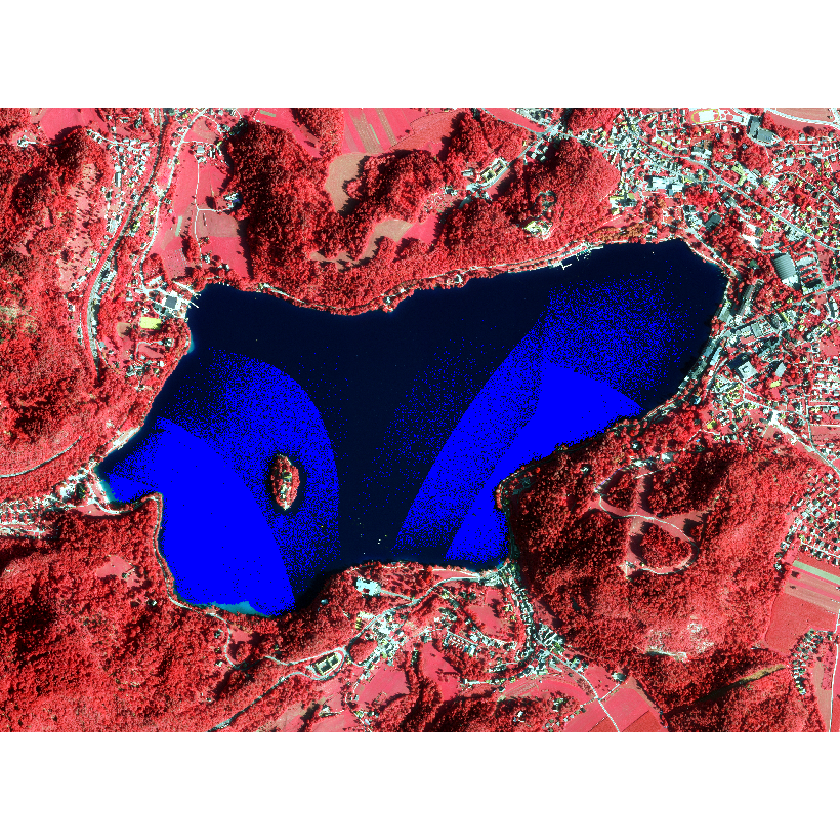

In [4]:
plotRGB(dofir, r=1, g=2, b=3, stretch="lin", colNA="blue")

We can create fuctions, calculate, analyse the data, plot

In [ ]:
ndvi <- function(x) { (x[1]-x[3])/(x[1]+x[3])}
# 211 s
tic()
ndvi_calc <- calc(dofir, ndvi)
toc()

plot(ndvi_calc,
     main = 'NDVI of around Bled Lake')

hist(ndvi_calc,
     main = "NDVI: Distribution of pixels around our area",
     col = "springgreen",
     xlab = "NDVI")

And make various plost (which we aren't so much into, so check others work)
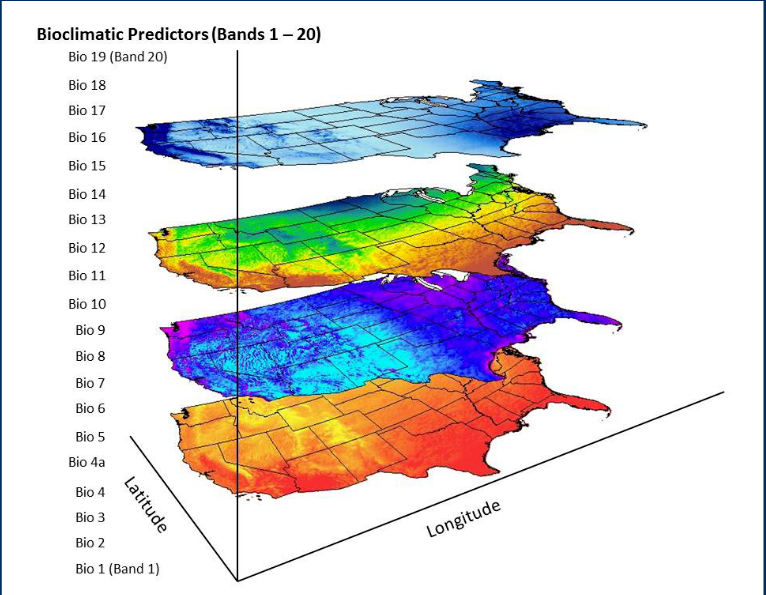https://i.stack.imgur.com/yyoHW.png

In [ ]:
#we can use some machine learning techniques as well
matrix_values <- getValues(our_raster)
nodata_values <- which(!is.na(matrix_values))
matrix_values <- na.omit(nodata_values)

##k-means classification
kmeans_values <- getValues(dofir)
nodata_values  <- which(!is.na(kmeans_values ))
kmeans_values  <- na.omit(kmeans_values )

#774 s
tic()
kmeans <- kmeans(kmeans_values, 8, iter.max = 100, nstart = 10)
kmeans_raster <- raster(dofir)
kmeans_raster[nodata_values] <- kmeans$cluster
toc()
plot(kmeans_raster)

With rpostgis we can write our R RasterLayer to PostGIS directly, but for now it's painfully slow


In [ ]:
tic()
pgWriteRast(conn,  c("public","kmeans_raster"), kmeans_raster, blocks = NULL)
toc()

We can also use other external libraries in this intermediate platform
The advantage of such workflows lays in the work in just one environment and a lot of options to test the state-of-the art alghoritms

In [ ]:
#154.197
tic()
system("otbcli_Segmentation -in /opt/workshop/exercise_3/DOF_NIR.tif -mode vector -mode.vector.out  /opt/workshop/exercise_3/Segmentation.shp -filter meanshift -filter.meanshift.spatialr  15 -filter.meanshift.ranger 20 -filter.meanshift.minsize 50")
toc()
#read the segments
segments <- readOGR(dsn = "/opt/workshop/exercise_3", layer = "Segmentation")
plot(segments, add)